In [1]:
# dropout example

import os
import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt


In [2]:
class deepMNISTDropout(nn.Module):
    
    def __init__(self, p=0.25):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, 3), #3*3*1*32 + 32
            nn.MaxPool2d(2,stride=2),
            nn.Tanh(),
            nn.Conv2d(32, 64, 3), #3*3*32*64 + 64
            nn.MaxPool2d(2,stride=2),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(1600, 1024), #1600*1024 + 1024
            nn.BatchNorm1d(1024), #1024*2
            nn.Tanh(),
            nn.Dropout1d(p),
            nn.Linear(1024, 10) # 1024*10+10
        )
        
    def forward(self, x):
        return self.layers(x)



In [3]:
# Set fixed random number seed for reproducibility
torch.manual_seed(52)

device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(), # converts pixel values to in [0,1]
    transforms.Normalize((0.5,), (0.5,)) 
    # given arguments (mean[1],...,mean[n]), (std[1],...,std[n]), normalizes the
    # input channels separately with output[i] = (input[i] - mean[i])/std[i] 
    # so this maps the pixels to the range [-1,1]
])

train_dataset = FashionMNIST(os.getcwd(), download=True, train=True, transform=transform) 
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=1)

val_dataset = FashionMNIST(os.getcwd(), download=True, train=False, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=1)

In [4]:
def train_epoch(model, criterion, optimizer, trainloader, verbose=True):
    model.train()
    numbatches = len(trainloader)
    if verbose: 
        print("Starting epoch")
        print("--------------")
    for (idx, (inputs, targets)) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (idx + 1) % 100 == 0:
            if verbose: print(f"\t Training loss on minibatch {idx+1}/{numbatches}: {loss.item():>5f}")
    if verbose:
        print("Finished epoch")
        print("--------------")

def validate(model, criterion, valloader):
    model.eval()
    test_loss = 0
    correct = 0
    numsamples = len(valloader.dataset)
    with torch.no_grad():
        for (idx, (inputs, targets)) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            correct += (outputs.argmax(1) == targets).type(torch.float).sum().item()
    loss = test_loss/numsamples
    accuracy = 100*correct/numsamples
    print(f"Validation loss/accuracy: {loss:>5f}/{accuracy:>5f}")
    return loss, accuracy

In [5]:
criterion = nn.CrossEntropyLoss()
lr = 1*1e-3
epochs = 20

naiveModel = deepMNISTDropout(0)
dropoutModel = deepMNISTDropout(0.25)

naiveModel.to(device)
dropoutModel.to(device)

optimizerNaive = torch.optim.Adam(naiveModel.parameters(), lr=lr)
optimizerDropout = torch.optim.Adam(dropoutModel.parameters(), lr=lr)

lossesNaive = []
lossesDropout = []

accuraciesNaive = []
accuraciesDropout = []

print("Training naive CNN")
print("------------------")
for e in range(epochs):
    train_epoch(naiveModel, criterion, optimizerNaive, train_loader, verbose=False)
    loss, accuracy = validate(naiveModel, criterion, val_loader)
    lossesNaive.append(loss)
    accuraciesNaive.append(accuracy)

print("------------------")

print("Training CNN with dropout")
print("------------------")
for e in range(epochs):
    train_epoch(dropoutModel, criterion, optimizerDropout, train_loader, verbose=False)
    loss, accuracy = validate(dropoutModel, criterion, val_loader)
    lossesDropout.append(loss)
    accuraciesDropout.append(accuracy)
print("------------------")


Training naive CNN
------------------
Validation loss/accuracy: 0.003114/85.860000
Validation loss/accuracy: 0.003029/86.110000
Validation loss/accuracy: 0.002512/88.890000
Validation loss/accuracy: 0.002285/89.890000
Validation loss/accuracy: 0.002887/88.300000
Validation loss/accuracy: 0.002579/88.930000
Validation loss/accuracy: 0.002318/90.370000
Validation loss/accuracy: 0.002278/90.760000
Validation loss/accuracy: 0.002700/90.210000
Validation loss/accuracy: 0.003181/89.680000
Validation loss/accuracy: 0.004278/87.150000
Validation loss/accuracy: 0.003103/90.190000
Validation loss/accuracy: 0.002731/91.300000
Validation loss/accuracy: 0.003268/90.300000
Validation loss/accuracy: 0.003665/89.460000
Validation loss/accuracy: 0.003460/90.370000
Validation loss/accuracy: 0.003674/90.360000
Validation loss/accuracy: 0.003426/90.560000
Validation loss/accuracy: 0.003477/90.900000
Validation loss/accuracy: 0.004095/90.510000
------------------
Training CNN with dropout
-----------------

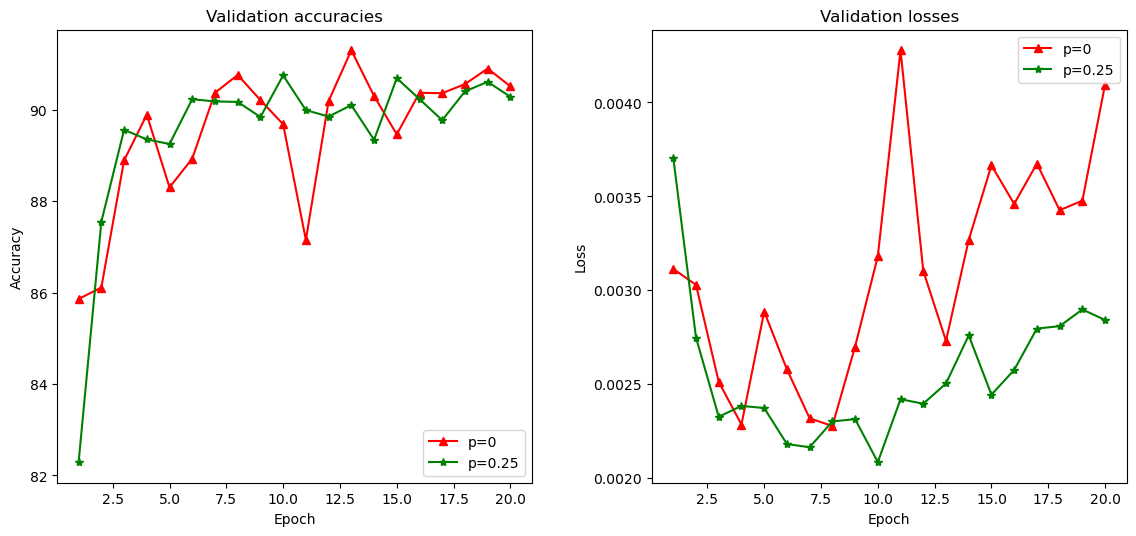

In [7]:
indicies = torch.arange(epochs)+1

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(indicies, accuraciesNaive, "r^", ls="-", label="p=0")
ax1.plot(indicies, accuraciesDropout, "g*", ls="-", label="p=0.25")
ax1.set_title("Validation accuracies")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend(loc="lower right")

ax2.plot(indicies, lossesNaive, "r^", ls="-", label="p=0")
ax2.plot(indicies, lossesDropout, "g*", ls="-", label="p=0.25")
ax2.set_title("Validation losses")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend(loc="upper right")

fig.set_size_inches(12, 6)
fig.tight_layout(pad=3.0)